In [10]:
!pip install -q u8darts[all]
!pip install -q statsforecast
!pip install -q prophet
!pip install -q statsmodels
!pip install -q pmdarima

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import io
from datetime import datetime
import warnings
warnings.filterwarnings("ignore", message="No frequency information was provided, so inferred frequency MS will be used.")

from darts import TimeSeries
from darts.metrics import mape

import pmdarima as pm
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from sklearn.linear_model import LinearRegression


In [12]:
from google.colab import files
uploaded = files.upload()
filename = list(uploaded.keys())[0]

df = pd.read_csv(io.BytesIO(uploaded[filename]))
df['date'] = pd.to_datetime(df['date'], format = '%Y-%m')
print(df.head())

Saving preprocessed_data.csv to preprocessed_data (1).csv
  series_id       date      value
0        T1 1979-01-01  1149.8700
1        T1 1979-02-01  1053.8002
2        T1 1979-03-01  1388.8798
3        T1 1979-04-01  1783.3702
4        T1 1979-05-01  1921.0252


각 시계열별 항목(행) 개수 (정렬됨):


,series_id,항목_개수
0,T1,187
1,T2,187
2,T3,264
3,T4,264
4,T5,264
...,...,...
361,T362,240
362,T363,240
363,T364,240
364,T365,240


측정 개월 수 통계:
count    366.000000
mean     298.579235
std       55.651489
min       91.000000
25%      264.000000
50%      330.000000
75%      333.000000
max      333.000000
dtype: float64


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49884 (\N{HANGUL SYLLABLE SI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44228 (\N{HANGUL SYLLABLE GYE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50676 (\N{HANGUL SYLLABLE YEOL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48324 (\N{HANGUL SYLLABLE BYEOL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr

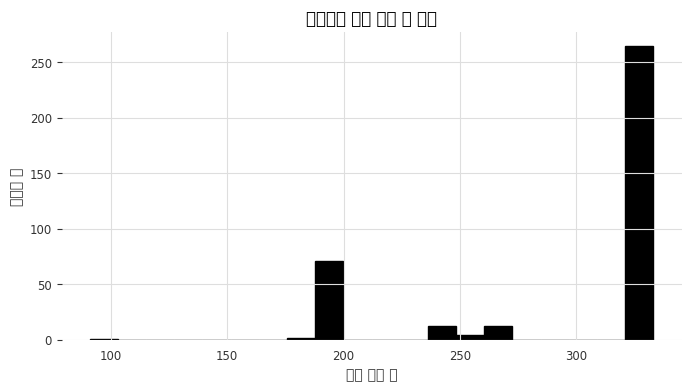

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54217 (\N{HANGUL SYLLABLE PYEONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44512 (\N{HANGUL SYLLABLE GYUN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51204 (\N{HANGUL SYLLABLE JEON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 52404 (\N{HANGUL SYLLABLE CE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49884 (\N{HANGUL SYLLABLE SI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/u

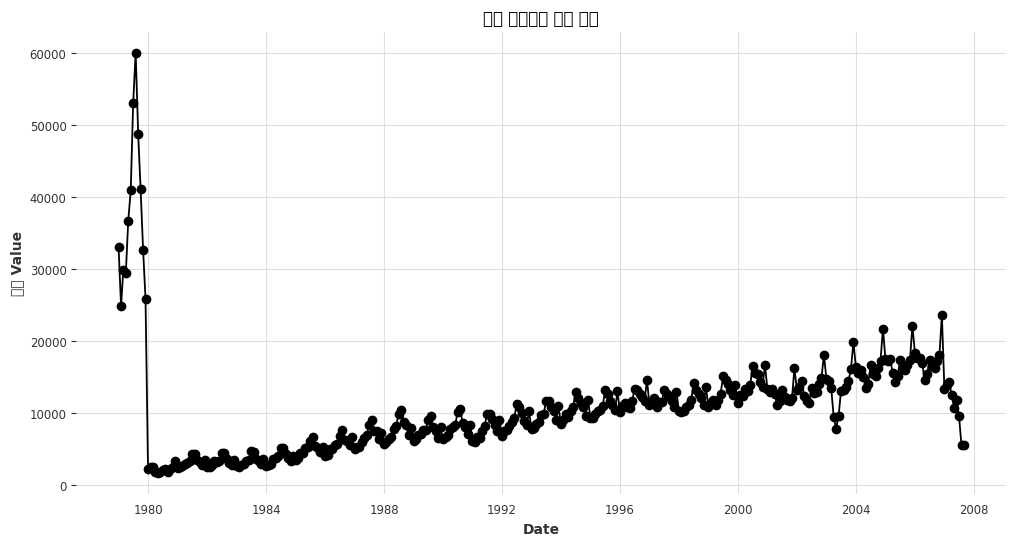

In [13]:
# 시계열 ID를 "T1, T2, T3, ..." 순으로 정렬
sorted_series_ids = sorted(df['series_id'].unique(),
                           key=lambda x: int(x[1:]) if isinstance(x, str) and x.startswith('T') else x)

# 각 시계열별 항목(행) 개수 테이블 및 분포 시각화
series_counts = pd.DataFrame({
    "series_id": sorted_series_ids,
    "항목_개수": [df[df['series_id'] == sid].shape[0] for sid in sorted_series_ids]
})
print("각 시계열별 항목(행) 개수 (정렬됨):")
display(series_counts)

series_length = df.groupby('series_id').size()
print("측정 개월 수 통계:")
print(series_length.describe())

plt.figure(figsize=(8,4))
plt.hist(series_length, bins=20, edgecolor='black')
plt.xlabel("측정 개월 수")
plt.ylabel("시계열 수")
plt.title("시계열별 측정 개월 수 분포")
plt.show()

# 전체 시계열 평균 추세 시각화
overall_trend = df.groupby('date')['value'].mean().reset_index()
plt.figure(figsize=(12,6))
plt.plot(overall_trend['date'], overall_trend['value'], marker='o')
plt.title("전체 시계열의 평균 추세")
plt.xlabel("Date")
plt.ylabel("평균 Value")
plt.grid(True)
plt.show()

In [14]:
# 평가 지표 함수 정의
def scaling_factor(train, m=12):
    y = train.values().flatten()
    if len(y) <= m:
        return np.nan
    diff = np.abs(y[m:] - y[:-m])
    return np.mean(diff)

def compute_mase(forecast, actual, train, m=12):
    scale = scaling_factor(train, m)
    if scale == 0 or np.isnan(scale):
        return np.nan
    errors = np.abs(forecast.values().flatten() - actual.values().flatten())
    return np.mean(errors) / scale

def compute_mdase(forecast, actual, train, m=12):
    scale = scaling_factor(train, m)
    if scale == 0 or np.isnan(scale):
        return np.nan
    errors = np.abs(forecast.values().flatten() - actual.values().flatten())
    return np.median(errors) / scale

def compute_pb(forecast, actual):
    forecast_vals = forecast.values().flatten()
    actual_vals = actual.values().flatten()
    if np.sum(actual_vals) == 0:
        return np.nan
    return 100 * np.sum(forecast_vals - actual_vals) / np.sum(actual_vals)


In [15]:
# 평가 함수: 각 시차 h=1,...,24에 대해 지표 계산 (평균 및 개별 h 결과)
def evaluate_forecast_by_h(forecast_ts, test_ts, train_ts):
    n = len(test_ts)
    metrics_h = {"PB": [], "MAPE": [], "MASE": [], "MdASE": []}
    for h in range(1, n+1):
        f_h = forecast_ts.slice_intersect(test_ts[:h])
        a_h = test_ts[:h]
        metrics_h["PB"].append(compute_pb(f_h, a_h))
        metrics_h["MAPE"].append(mape(a_h, f_h)*100)
        metrics_h["MASE"].append(compute_mase(f_h, a_h, train_ts, m=12))
        metrics_h["MdASE"].append(compute_mdase(f_h, a_h, train_ts, m=12))
    avg_metrics = {k: np.nanmean(v) for k,v in metrics_h.items()}
    return avg_metrics, metrics_h

In [16]:
# ARIMA

def ARIMAX_optimizer(y, X=None):
    results = []
    # p와 q의 범위를 0~3까지 탐색 (교재 ARIMA 모델 챕터 참조)
    for p in range(4):
        for q in range(4):
            try:
                # exogenous 변수가 없는 경우 X=None 처리
                model = SARIMAX(y, exog=X, order=(p, 0, q), simple_differencing=False).fit(disp=False)
            except Exception as e:
                continue
            aic = model.aic
            results.append([p, q, aic])
    result_df = pd.DataFrame(results, columns=['p', 'q', 'AIC'])
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    return result_df

arima_results_series = []
for sid in sorted_series_ids:
    df_sid = df[df['series_id'] == sid].sort_values('date')
    if df_sid.shape[0] < 36:
        continue
    # 마지막 24개월은 test set, 나머지는 train set으로 분할
    train_df = df_sid.iloc[:-24]
    test_df  = df_sid.iloc[-24:]
    # 날짜를 index로 설정한 pandas Series 생성
    train_series = train_df.set_index('date')['value']
    test_series  = test_df.set_index('date')['value']

    # ARIMAX 모형 최적화 (exogenous 변수 없음)
    opt_df = ARIMAX_optimizer(train_series, X=None)
    if opt_df.empty:
        print(f"ARIMA 모형 최적화 실패 (series {sid})")
        continue
    best_p, best_q = opt_df.loc[0, ['p', 'q']]

    start = time.time()
    try:
        model = SARIMAX(train_series, exog=None, order=(int(best_p), 0, int(best_q)), simple_differencing=False).fit(disp=False)
        forecast_vals = model.forecast(steps=24)
    except Exception as e:
        print(f"ARIMA 에러 (series {sid}): {e}")
        continue
    exec_time = time.time() - start

    # Darts TimeSeries 객체로 변환 (교재 예제에 따른 변환)
    forecast_ts = TimeSeries.from_series(pd.Series(forecast_vals, index=test_series.index))
    test_ts = TimeSeries.from_series(test_series)
    train_ts = TimeSeries.from_series(train_series)

    avg_metrics, _ = evaluate_forecast_by_h(forecast_ts, test_ts, train_ts)
    avg_metrics["exec_time"] = exec_time
    avg_metrics["series_id"] = sid
    arima_results_series.append(avg_metrics)

arima_results_df = pd.DataFrame(arima_results_series)
print("ARIMA 평가 결과 (각 시계열별 평균):")
display(arima_results_df)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/s

ARIMA 평가 결과 (각 시계열별 평균):


,PB,MAPE,MASE,MdASE,exec_time,series_id
0,2.808996,2200.061918,3.885443,3.668556,1.906058,T1
1,4.118973,1811.125775,1.913672,1.655153,0.889239,T2
2,-12.499924,1613.919765,1.685519,1.728252,0.455588,T3
3,-9.475106,1467.970439,1.771238,1.543598,0.323208,T4
4,-2.932441,1026.378208,1.151355,0.945822,0.407857,T5
...,...,...,...,...,...,...
361,-89.570065,9267.029903,8.838433,5.741556,0.038320,T362
362,-74.123970,33339.482043,1.640394,1.323879,0.416215,T363
363,1.211997,2813.825058,1.381923,1.226256,1.505477,T364
364,-1.433071,1865.083928,0.513887,0.475380,0.415946,T365


In [17]:
from statsmodels.tsa.exponential_smoothing.ets import ETSModel

def select_ets_model(train_series):
    # ETSModel 후보
    candidates = [
        {"error": "add", "trend": None, "seasonal": None, "damped_trend": False},
        {"error": "add", "trend": "add", "seasonal": None, "damped_trend": False},
        {"error": "add", "trend": None, "seasonal": "add", "damped_trend": False},
        {"error": "add", "trend": "add", "seasonal": "add", "damped_trend": False},
        {"error": "mul", "trend": "add", "seasonal": "mul", "damped_trend": False},
        {"error": "mul", "trend": "mul", "seasonal": "add", "damped_trend": False},
        {"error": "mul", "trend": "mul", "seasonal": "mul", "damped_trend": False},
        {"error": "add", "trend": "add", "seasonal": "add", "damped_trend": True},
        {"error": "mul", "trend": "mul", "seasonal": "mul", "damped_trend": True},
    ]
    best_aic = np.inf
    best_params = None
    best_model = None
    for params in candidates:
        try:
            model = ETSModel(train_series,
                             error=params["error"],
                             trend=params["trend"],
                             seasonal=params["seasonal"],
                             damped_trend=params["damped_trend"],
                             seasonal_periods=12)
            fitted_model = model.fit()
            aic_val = fitted_model.aic
            if aic_val < best_aic:
                best_aic = aic_val
                best_params = params
                best_model = fitted_model
        except Exception as e:
            continue
    return best_model, best_params

def ets_forecast_with_pi(train_series, steps=24, nsim=100, alpha=0.05):
    best_model, best_params = select_ets_model(train_series)
    if best_model is None:
        return None, None
    # 점 예측
    forecast_vals = best_model.forecast(steps)
    # 부트스트랩을 통한 예측구간 산출
    sim_forecasts = []
    for i in range(nsim):
        try:
            sim = best_model.simulate(steps)
            sim_forecasts.append(sim)
        except Exception:
            sim = forecast_vals + np.random.normal(scale=np.std(forecast_vals), size=steps)
            sim_forecasts.append(sim)
    sim_forecasts = np.array(sim_forecasts)
    lower_pi = np.percentile(sim_forecasts, 100*alpha/2, axis=0)
    upper_pi = np.percentile(sim_forecasts, 100*(1-alpha/2), axis=0)
    return forecast_vals, (lower_pi, upper_pi)

def run_ETS(df, sorted_series_ids):
    results = []
    for sid in sorted_series_ids:
        df_sid = df[df['series_id'] == sid].sort_values('date')
        if df_sid.shape[0] < 36:
            continue
        # train/test 분할: 마지막 24개월은 test, 나머지는 train
        train_df = df_sid.iloc[:-24]
        test_df  = df_sid.iloc[-24:]
        train_series = train_df.set_index('date')['value']
        test_series  = test_df.set_index('date')['value']
        start = time.time()
        try:
            forecast_vals, pi = ets_forecast_with_pi(train_series, steps=24, nsim=100, alpha=0.05)
            if forecast_vals is None:
                continue
        except Exception as e:
            print(f"ETS 에러 (series {sid}): {e}")
            continue
        exec_time = time.time() - start
        # Darts TimeSeries 객체로 변환
        forecast_ts = TimeSeries.from_series(pd.Series(forecast_vals, index=test_series.index))
        test_ts = TimeSeries.from_series(test_series)
        train_ts = TimeSeries.from_series(train_series)
        # 평가 지표 계산 (교재 평가 방법 참조)
        avg_metrics, _ = evaluate_forecast_by_h(forecast_ts, test_ts, train_ts)
        lower_pi, upper_pi = pi
        coverage = np.mean((test_series.values >= lower_pi) & (test_series.values <= upper_pi))
        avg_metrics["coverage"] = coverage
        avg_metrics["exec_time"] = exec_time
        avg_metrics["series_id"] = sid
        results.append(avg_metrics)
    return pd.DataFrame(results)

ets_results_df = run_ETS(df, sorted_series_ids)
print("ETS 평가 결과:")
display(ets_results_df)

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/exponential_smoothing/ets.py:1232: RuntimeWarning: invalid value encountered in divide
  return (data - yhat) / yhat
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/exponential_smoothing/ets.py:1173: RuntimeWarning: divide by zero encountered in log
  logL -= np.sum(np.log(yhat))
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/exponential_smoothing/ets.py:1232: RuntimeWarning: overflow encountered in divide
  return (data - yhat) / yhat
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/exponential_smoothing/ets.py:1172: RuntimeWarning: invalid value encountered in less_equal
  yhat[yhat <= 0] = 1 / (1e-8 * (1 + np.abs(yhat[yhat <= 0])))
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa

ETS 평가 결과:


,PB,MAPE,MASE,MdASE,coverage,exec_time,series_id
0,-8.461560,1029.228793,1.538806,1.493647,0.250000,1.564463,T1
1,-0.770306,583.377135,0.768009,0.643462,0.166667,1.265032,T2
2,-5.419713,613.083870,0.649486,0.745528,0.041667,1.156034,T3
3,-2.123087,476.975011,0.528070,0.372128,0.000000,1.096287,T4
4,-9.814835,963.086874,1.237532,1.127699,0.000000,1.388913,T5
...,...,...,...,...,...,...,...
361,-38.864318,3951.161638,3.573776,1.806291,0.666667,4.039353,T362
362,-14.902152,3232.880113,0.953512,0.552890,0.333333,5.002417,T363
363,17.471951,2272.753747,0.861357,0.540636,0.958333,1.812488,T364
364,1.752549,945.719649,0.303396,0.219689,0.875000,2.036661,T365


In [18]:
# Theta

def theta_forecast(train_series, steps=24):
    # 시계열 분해 (교재 Theta 모델 챕터 참고)
    decomp = seasonal_decompose(train_series, model='multiplicative', period=12, extrapolate_trend='freq')
    seasonal_factors = decomp.seasonal[-12:]
    deseasonalized = train_series / decomp.seasonal
    try:
        ses_model = SimpleExpSmoothing(deseasonalized).fit(optimized=True)
        ses_forecast = ses_model.forecast(steps)
    except Exception as e:
        ses_forecast = np.full(steps, np.nan)
    n = len(deseasonalized)
    X = np.arange(n).reshape(-1,1)
    lr = LinearRegression().fit(X, deseasonalized.values)
    future_X = np.arange(n, n+steps).reshape(-1,1)
    trend_forecast = lr.predict(future_X)
    deseasonalized_forecast = 0.5 * (ses_forecast + trend_forecast)
    seasonal_cycle = np.tile(seasonal_factors.values, int(np.ceil(steps/12)))[:steps]
    final_forecast = deseasonalized_forecast * seasonal_cycle
    return final_forecast

theta_results_series = []
for sid in sorted_series_ids:
    df_sid = df[df['series_id'] == sid].sort_values('date')
    if df_sid.shape[0] < 36:
        continue
    train_df = df_sid.iloc[:-24]
    test_df  = df_sid.iloc[-24:]
    train_series = train_df.set_index('date')['value']
    test_series  = test_df.set_index('date')['value']

    start = time.time()
    try:
        forecast_vals = theta_forecast(train_series, steps=24)
    except Exception as e:
        print(f"Theta 에러 (series {sid}): {e}")
        continue
    exec_time = time.time() - start
    forecast_ts = TimeSeries.from_series(pd.Series(forecast_vals, index=test_series.index))
    test_ts = TimeSeries.from_series(test_series)
    train_ts = TimeSeries.from_series(train_series)

    avg_metrics, _ = evaluate_forecast_by_h(forecast_ts, test_ts, train_ts)
    avg_metrics["exec_time"] = exec_time
    avg_metrics["series_id"] = sid
    theta_results_series.append(avg_metrics)

theta_results_df = pd.DataFrame(theta_results_series)
print("Theta 평가 결과 (각 시계열별 평균):")
display(theta_results_df)

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_

Theta 에러 (series T45): Multiplicative seasonality is not appropriate for zero and negative values


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


Theta 에러 (series T61): Multiplicative seasonality is not appropriate for zero and negative values
Theta 에러 (series T63): Multiplicative seasonality is not appropriate for zero and negative values
Theta 에러 (series T64): Multiplicative seasonality is not appropriate for zero and negative values


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


Theta 에러 (series T82): Multiplicative seasonality is not appropriate for zero and negative values
Theta 에러 (series T97): Multiplicative seasonality is not appropriate for zero and negative values


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


Theta 에러 (series T109): Multiplicative seasonality is not appropriate for zero and negative values
Theta 에러 (series T111): Multiplicative seasonality is not appropriate for zero and negative values


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


Theta 에러 (series T116): Multiplicative seasonality is not appropriate for zero and negative values
Theta 에러 (series T117): Multiplicative seasonality is not appropriate for zero and negative values


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


Theta 에러 (series T133): Multiplicative seasonality is not appropriate for zero and negative values
Theta 에러 (series T134): Multiplicative seasonality is not appropriate for zero and negative values
Theta 에러 (series T142): Multiplicative seasonality is not appropriate for zero and negative values
Theta 에러 (series T145): Multiplicative seasonality is not appropriate for zero and negative values
Theta 에러 (series T160): Multiplicative seasonality is not appropriate for zero and negative values
Theta 에러 (series T163): Multiplicative seasonality is not appropriate for zero and negative values
Theta 에러 (series T165): Multiplicative seasonality is not appropriate for zero and negative values
Theta 에러 (series T167): Multiplicative seasonality is not appropriate for zero and negative values
Theta 에러 (series T168): Multiplicative seasonality is not appropriate for zero and negative values
Theta 에러 (series T170): Multiplicative seasonality is not appropriate for zero and negative values
Theta 에러 (

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


Theta 에러 (series T184): Multiplicative seasonality is not appropriate for zero and negative values
Theta 에러 (series T203): Multiplicative seasonality is not appropriate for zero and negative values
Theta 에러 (series T204): Multiplicative seasonality is not appropriate for zero and negative values
Theta 에러 (series T218): Multiplicative seasonality is not appropriate for zero and negative values
Theta 에러 (series T219): Multiplicative seasonality is not appropriate for zero and negative values
Theta 에러 (series T220): Multiplicative seasonality is not appropriate for zero and negative values
Theta 에러 (series T221): Multiplicative seasonality is not appropriate for zero and negative values
Theta 에러 (series T227): Multiplicative seasonality is not appropriate for zero and negative values
Theta 에러 (series T228): Multiplicative seasonality is not appropriate for zero and negative values
Theta 에러 (series T229): Multiplicative seasonality is not appropriate for zero and negative values
Theta 에러 (

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


Theta 에러 (series T332): Multiplicative seasonality is not appropriate for zero and negative values
Theta 에러 (series T333): Multiplicative seasonality is not appropriate for zero and negative values


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_

Theta 평가 결과 (각 시계열별 평균):


,PB,MAPE,MASE,MdASE,exec_time,series_id
0,-0.252122,501.850505,0.882820,0.762113,0.051046,T1
1,4.206592,618.948133,0.861294,0.571079,0.017819,T2
2,-10.652721,1032.506547,1.081451,1.174439,0.020518,T3
3,-8.484676,982.550855,1.140810,0.997298,0.018126,T4
4,-18.679858,1820.398433,2.290376,2.274682,0.016907,T5
...,...,...,...,...,...,...
300,-29.025487,6085.756475,3.479467,1.375604,0.012627,T362
301,-6.236564,6362.432398,1.204666,0.744257,0.012212,T363
302,7.289503,1549.628099,0.608925,0.397227,0.011089,T364
303,-5.738252,941.845190,0.272911,0.282408,0.012619,T365


In [19]:
from darts.models import ExponentialSmoothing

In [20]:
# SES

ses_results = []
for sid in sorted_series_ids:
    df_sid = df[df['series_id'] == sid].sort_values('date')
    ts = TimeSeries.from_dataframe(df_sid, time_col='date', value_cols='value')
    if len(ts) < 36:
        continue
    train = ts[:-24]
    test = ts[-24:]
    start = time.time()
    try:
        # Darts의 ExponentialSmoothing (SES: trend, seasonal 없음)
        model_ses = ExponentialSmoothing(trend=None, seasonal=None, optimized=True)
        model_ses.fit(train)
        forecast = model_ses.predict(len(test))
    except Exception as e:
        print(f"SES 모델 에러 (series {sid}): {e}")
        continue
    exec_time = time.time() - start
    pb_val = compute_pb(forecast, test)
    mape_val = mape(test, forecast) * 100
    mase_val = compute_mase(forecast, test, train, m=12)
    mdase_val = compute_mdase(forecast, test, train, m=12)
    ses_results.append({
        "series_id": sid,
        "PB": pb_val,
        "MAPE (%)": mape_val,
        "MASE": mase_val,
        "MdASE": mdase_val,
        "exec_time": exec_time
    })

ses_results_df = pd.DataFrame(ses_results)
print("SES 평가 결과:")
display(ses_results_df)

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_

SES 평가 결과:


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


,series_id,PB,MAPE (%),MASE,MdASE,exec_time
0,T1,75.340977,11413.380291,14.749575,16.212212,0.012044
1,T2,32.097695,4346.545901,4.268953,4.958248,0.008334
2,T3,-1.019896,1079.777313,1.084663,0.838665,0.008754
3,T4,6.099440,1801.036423,2.003430,1.708122,0.009570
4,T5,-12.339892,1491.234233,1.964858,1.951022,0.011745
...,...,...,...,...,...,...
361,T362,-98.186054,7839.944807,10.799547,6.489588,0.016428
362,T363,-94.759626,11407.839358,5.506507,6.310642,0.009351
363,T364,7.192549,2692.228289,1.111709,1.039535,0.012062
364,T365,-45.235662,4096.255649,1.804857,1.527036,0.012994


In [21]:
from tbats import TBATS  # tbats 패키지에서 TBATS 임포트

tbats_results = []
for sid in sorted_series_ids:
    df_sid = df[df['series_id'] == sid].sort_values('date')
    # NaN 제거
    df_sid = df_sid.dropna(subset=['value'])
    if df_sid.shape[0] < 36:
        continue
    train_df = df_sid.iloc[:-24]
    test_df  = df_sid.iloc[-24:]
    train_series = train_df.set_index('date')['value']
    test_series  = test_df.set_index('date')['value']

    # TBATS 모델 설정 (교재 TBATS 챕터 참고)
    estimator = TBATS(seasonal_periods=[12],
                      use_arma_errors=False,
                      use_box_cox=False,
                      show_warnings=False)

    start = time.time()
    try:
        model_tbats = estimator.fit(train_series)
        forecast_vals = model_tbats.forecast(steps=24)
        nsim = 50  # 시뮬레이션 횟수 감소
        sim_forecasts = []
        for i in range(nsim):
            try:
                sim = model_tbats.simulate(steps=24)
                sim_forecasts.append(sim)
            except Exception:
                sim = forecast_vals + np.random.normal(scale=np.std(forecast_vals), size=24)
                sim_forecasts.append(sim)
        sim_forecasts = np.array(sim_forecasts)
        lower_pi = np.percentile(sim_forecasts, 2.5, axis=0)
        upper_pi = np.percentile(sim_forecasts, 97.5, axis=0)
    except Exception as e:
        print(f"TBATS 모델 에러 (series {sid}): {e}")
        continue
    exec_time = time.time() - start

    forecast_ts = TimeSeries.from_series(pd.Series(forecast_vals, index=test_series.index))
    test_ts = TimeSeries.from_series(test_series)
    train_ts = TimeSeries.from_series(train_series)

    pb_val = compute_pb(forecast_ts, test_ts)
    mape_val = mape(test_ts, forecast_ts) * 100
    mase_val = compute_mase(forecast_ts, test_ts, train_ts, m=12)
    mdase_val = compute_mdase(forecast_ts, test_ts, train_ts, m=12)
    coverage = np.mean((test_series.values >= lower_pi) & (test_series.values <= upper_pi))

    tbats_results.append({
        "series_id": sid,
        "PB": pb_val,
        "MAPE (%)": mape_val,
        "MASE": mase_val,
        "MdASE": mdase_val,
        "coverage": coverage,
        "exec_time": exec_time
    })

tbats_results_df = pd.DataFrame(tbats_results)
print("TBATS 평가 결과:")
display(tbats_results_df)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

TBATS 평가 결과:


,series_id,PB,MAPE (%),MASE,MdASE,coverage,exec_time
0,T1,-7.645112,786.972555,1.548706,1.064203,1.000000,14.635926
1,T2,-5.569049,708.520804,0.930468,0.690864,1.000000,13.285528
2,T3,-17.141253,1726.955526,1.841520,1.792043,0.125000,22.935625
3,T4,-15.874493,1613.109157,2.087956,1.752700,0.500000,14.620164
4,T5,-30.513469,3031.374380,4.009154,4.161180,0.083333,14.327111
...,...,...,...,...,...,...,...
361,T362,-20.024798,36849.403532,3.888190,2.197441,1.000000,16.778847
362,T363,-13.679510,9817.485959,1.043204,0.634340,1.000000,14.636906
363,T364,12.347488,2606.045711,1.005480,0.637086,0.875000,14.707082
364,T365,14.588002,1951.121938,0.735788,0.752112,1.000000,15.289341


In [22]:
# Prophet

from darts.models import Prophet as DartsProphet

prophet_results = []
for sid in sorted_series_ids:
    df_sid = df[df['series_id'] == sid].sort_values('date')
    ts = TimeSeries.from_dataframe(df_sid, time_col='date', value_cols='value')
    if len(ts) < 36:
        continue
    train = ts[:-24]
    test = ts[-24:]
    start = time.time()
    try:
        model_prophet = DartsProphet()
        model_prophet.fit(train)
        forecast = model_prophet.predict(len(test))
    except Exception as e:
        print(f"Prophet 모델 에러 (series {sid}): {e}")
        continue
    exec_time = time.time() - start
    pb_val = compute_pb(forecast, test)
    mape_val = mape(test, forecast) * 100
    mase_val = compute_mase(forecast, test, train, m=12)
    mdase_val = compute_mdase(forecast, test, train, m=12)
    prophet_results.append({
        "series_id": sid,
        "PB": pb_val,
        "MAPE (%)": mape_val,
        "MASE": mase_val,
        "MdASE": mdase_val,
        "exec_time": exec_time
    })

prophet_results_df = pd.DataFrame(prophet_results)
print("Prophet 평가 결과:")
display(prophet_results_df)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvqhb53xl/0pmaojit.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvqhb53xl/_iw04gbg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69538', 'data', 'file=/tmp/tmpvqhb53xl/0pmaojit.json', 'init=/tmp/tmpvqhb53xl/_iw04gbg.json', 'output', 'file=/tmp/tmpvqhb53xl/prophet_modelprz9jf38/prophet_model-20250313024339.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:43:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:43:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonalit

Prophet 평가 결과:


,series_id,PB,MAPE (%),MASE,MdASE,exec_time
0,T1,-7.341806,757.351715,1.503401,0.988504,0.545067
1,T2,-17.701357,1773.562862,2.170205,1.922983,0.095746
2,T3,-14.745873,1442.694659,1.544792,1.372450,0.095991
3,T4,-18.322063,1734.743181,2.237251,2.161408,0.093728
4,T5,-34.368761,3386.293633,4.429520,4.571593,0.133530
...,...,...,...,...,...,...
361,T362,9.945344,107472.840037,4.485869,4.694859,0.099759
362,T363,-40.530844,49460.141602,2.315718,1.941446,0.119346
363,T364,10.641875,2320.016173,0.895665,0.582254,0.149284
364,T365,-9.408964,3037.289727,0.698906,0.710087,0.123246


In [23]:
# 이후 최종 평가 결과 집계 코드 실행
def aggregate_results(df_model, model_name):
    agg = df_model.mean(numeric_only=True)
    agg["model"] = model_name
    return agg

arima_agg = aggregate_results(arima_results_df, "ARIMA")
ets_agg   = aggregate_results(ets_results_df, "ETS")
theta_agg = aggregate_results(theta_results_df, "Theta")
ses_agg   = aggregate_results(ses_results_df, "SES")
tbats_agg = aggregate_results(tbats_results_df, "TBATS")
prophet_agg = aggregate_results(prophet_results_df, "Prophet")

final_summary = pd.DataFrame([arima_agg, ets_agg, theta_agg, ses_agg, tbats_agg, prophet_agg])
cols = ["model", "PB", "MAPE (%)", "MASE", "MdASE", "coverage", "exec_time"]
for c in cols:
    if c not in final_summary.columns:
        final_summary[c] = np.nan
final_summary = final_summary[cols]
print("최종 평가 결과 (모델별 평균):")
display(final_summary)


최종 평가 결과 (모델별 평균):


,model,PB,MAPE (%),MASE,MdASE,coverage,exec_time
0,ARIMA,80.288701,NaN,27.202658,35.367035,NaN,0.463367
1,ETS,0.517598,NaN,1.416574,1.215904,0.129895,1.602543
2,Theta,0.281267,NaN,1.596956,1.326240,NaN,0.014988
3,SES,-15.349895,3920.279578,3.296694,2.533296,NaN,0.012473
4,TBATS,-8.549084,2820.215856,2.156939,1.673071,0.659039,14.986998
5,Prophet,-1.317994,3808.479766,2.224224,1.961098,NaN,0.141842


In [24]:
# 평균 순위 산출 (각 지표별 순위 후 평균)
final_summary["rank"] = final_summary[["MAPE (%)", "MASE", "MdASE"]].mean(axis=1).rank()
print("모델별 평균 순위:")
display(final_summary.sort_values("rank"))

모델별 평균 순위:


,model,PB,MAPE (%),MASE,MdASE,coverage,exec_time,rank
1,ETS,0.517598,NaN,1.416574,1.215904,0.129895,1.602543,1.0
2,Theta,0.281267,NaN,1.596956,1.326240,NaN,0.014988,2.0
0,ARIMA,80.288701,NaN,27.202658,35.367035,NaN,0.463367,3.0
4,TBATS,-8.549084,2820.215856,2.156939,1.673071,0.659039,14.986998,4.0
5,Prophet,-1.317994,3808.479766,2.224224,1.961098,NaN,0.141842,5.0
3,SES,-15.349895,3920.279578,3.296694,2.533296,NaN,0.012473,6.0


In [26]:
def aggregate_results(df_model, model_name):
    # 각 모델 결과 DataFrame의 수치형 평가 지표(평균)를 계산
    agg = df_model.mean(numeric_only=True)
    agg["model"] = model_name
    return agg

# 각 모델별 집계 결과 생성 (평균 평가 결과)
arima_agg   = aggregate_results(arima_results_df, "ARIMA")
ets_agg     = aggregate_results(ets_results_df, "ETS")
theta_agg   = aggregate_results(theta_results_df, "Theta")
ses_agg     = aggregate_results(ses_results_df, "SES")
tbats_agg   = aggregate_results(tbats_results_df, "TBATS")
prophet_agg = aggregate_results(prophet_results_df, "Prophet")

# 최종 평가 결과 DataFrame 생성
final_summary = pd.DataFrame([arima_agg, ets_agg, theta_agg, ses_agg, tbats_agg, prophet_agg])

# 필요한 컬럼 순서 정렬: coverage 컬럼은 일부 모델에는 없을 수 있으므로, 없는 경우 NaN으로 채움
cols = ["model", "PB", "MAPE (%)", "MASE", "MdASE", "coverage", "exec_time"]
for c in cols:
    if c not in final_summary.columns:
        final_summary[c] = np.nan
final_summary = final_summary[cols]

print("최종 평가 결과 (모델별 평균):")
print(final_summary)

# 각 모델의 평가 지표("MAPE (%)", "MASE", "MdASE")의 평균을 기준으로 순위를 산출
final_summary["rank"] = final_summary[["MAPE (%)", "MASE", "MdASE"]].mean(axis=1).rank()
print("모델별 평균 순위 (낮을수록 좋음):")
print(final_summary.sort_values("rank"))

최종 평가 결과 (모델별 평균):
     model         PB     MAPE (%)       MASE      MdASE  coverage  exec_time
0    ARIMA  80.288701          NaN  27.202658  35.367035       NaN   0.463367
1      ETS   0.517598          NaN   1.416574   1.215904  0.129895   1.602543
2    Theta   0.281267          NaN   1.596956   1.326240       NaN   0.014988
3      SES -15.349895  3920.279578   3.296694   2.533296       NaN   0.012473
4    TBATS  -8.549084  2820.215856   2.156939   1.673071  0.659039  14.986998
5  Prophet  -1.317994  3808.479766   2.224224   1.961098       NaN   0.141842
모델별 평균 순위 (낮을수록 좋음):
     model         PB     MAPE (%)       MASE      MdASE  coverage  exec_time  \
1      ETS   0.517598          NaN   1.416574   1.215904  0.129895   1.602543   
2    Theta   0.281267          NaN   1.596956   1.326240       NaN   0.014988   
0    ARIMA  80.288701          NaN  27.202658  35.367035       NaN   0.463367   
4    TBATS  -8.549084  2820.215856   2.156939   1.673071  0.659039  14.986998   
5  Prophe

In [27]:
# 최종 평가 결과에서 평균 순위가 가장 낮은 모델 선택
best_model = final_summary.sort_values("rank").iloc[0]

print("최종적으로 가장 좋은 모델:", best_model["model"])
print("평균 순위:", best_model["rank"])
print("세부 평가 결과:")
print(best_model)

최종적으로 가장 좋은 모델: ETS
평균 순위: 1.0
세부 평가 결과:
model             ETS
PB           0.517598
MAPE (%)          NaN
MASE         1.416574
MdASE        1.215904
coverage     0.129895
exec_time    1.602543
rank              1.0
Name: 1, dtype: object
